# How Does Metropolitan Sustainability Efforts Influence Housing Prices in the Greater Washington Area?




In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, utils
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')
jv_path = '/content/drive/MyDrive/S2024/CS 364M/ML 2 final project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
'''
Load datasets:
    - National Walkability Index datasets (try except block for Shiyu's and Josiah's own dataset path)
    - Census tract to zipcode dataset; contains most national census tracts and respective zip codes
    - Electric vehicles in Washington state
    - Zillow home value index, home value forecast growth rates, and for sale listings
'''
try:
    walkability_all = pd.read_csv('EPA_SmartLocationDatabase_V3.csv')
    tract_zip = pd.read_excel('TRACT_ZIP_032024.xlsx')
    ev_data = pd.read_csv('EV_population.csv')
    zhvf_zipcode_growth = pd.read_csv('Zip_zhvf_growth_smooth_zipcode.csv')
    zhvi_zipcode = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
except:
    walkability_all = pd.read_csv(jv_path + 'EPA_SmartLocationDatabase_V3.csv')
    tract_zip = pd.read_excel(jv_path + 'TRACT_ZIP_032024.xlsx')
    ev_data = pd.read_csv(jv_path + 'EV_population.csv')
    zhvf_zipcode_growth = pd.read_csv(jv_path + 'Zip_zhvf_growth_smooth_zipcode.csv')
    zhvi_zipcode = pd.read_csv(jv_path + 'Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

## GEOID Structure
---
A complete GEOID for a census tract is constructed by concatenating:
- STATEFP (2 digits): State FIPS code
- COUNTYFP (3 digits): County FIPS code
- TRACTCE (6 digits): Census tract code, includes 6-n leading zeroes where n = len(TRACTCE)

## Desired Unified Dataframe

---

For median home value (ZHVI), home value forecast growths (ZHVF), and median sales price, we take the median for each (except growths) of the last 5 years, since walkability and EV dataset are of the last 5 years.

### Example Unified Dataset Data Point

| Zip Code | Walkability Index Score | EV Count | Median ZHVI | ZHVF Growth Avg |
|-|-|-|-|-|
|98282|10|859|734023.3|0.23|

In [69]:
'''
Merging and unifying all relevant datasets based on zipcode to yield a dataframe
containing: Zipcode, Walkability Index Score, EV Count, Median ZHVI, Avg ZHVF Growth
'''
def find_blk_tract(tract, tract_to_zip):
    blk = 1
    # Try block group numbers from 1-15 to see if there's a valid BLKGRP to return
    while blk < 15:
        potent_tract = str(int(tract) + blk)
        if int(potent_tract) in tract_to_zip['TRACT'].values:
            return potent_tract
        blk += 1
    # If no valid BLKGRP, then the tract probably doesn't exist... return something
    return tract

def get_tract(row, tract_to_zip):
    state_count_fp = str(row['STATEFP']) + str(row['COUNTYFP']).zfill(3)
    tract_ce = row['TRACTCE']
    blkgrp_ce = row['BLKGRPCE']
    tract_w_blk = tract_ce + blkgrp_ce
    tract_num_blk = state_count_fp + str(tract_w_blk).zfill(6)
    tract_num_reg = state_count_fp + str(tract_ce).zfill(6)

    blk_tract_in_table = int(tract_num_blk) in tract_to_zip['TRACT'].values
    reg_tract_in_table = int(tract_num_reg) in tract_to_zip['TRACT'].values

    # If census tract with BLKGRP in it exists in table
    if blk_tract_in_table:
        return tract_num_blk
    # Or if the regular tract code exists
    elif reg_tract_in_table:
        return tract_num_reg
    else:
        # If none exist then probably extraneous block group, return a valid BLKGRP
        return find_blk_tract(tract_num_reg, tract_to_zip)

# Filter walkability index ds to just Washington state indices and create column
# that takes the FIPS codes provided and makes a more complete GEOID
walkability = walkability_all[walkability_all['STATEFP'] == 53].copy()

walkability.loc[:, 'TRACT'] = walkability.apply(get_tract, axis=1, tract_to_zip = tract_zip)
walkability['TRACT'] = walkability['TRACT'].astype(int)

# Standardizing edge case for when no transit service exists in a certain zipcode
walkability.loc[walkability['D4E'] == -99999, 'D4E'] = 0
walkability.loc[walkability['D4C'] == -99999, 'D4C'] = 0
walkability_grouped = walkability.groupby('TRACT').agg({'NatWalkInd': 'mean',
                                                        'TotPop': 'sum',
                                                        'TotEmp': 'sum',
                                                        'D4E': 'mean',
                                                        'D4C': 'mean',
                                                        'D3A': 'mean'}).reset_index()

# Join with {tract <-> zipcode} dataset to align with rest of data
merged_walk_tract_zip = pd.merge(walkability_grouped, tract_zip, on='TRACT', how='inner')
# Impute missing values in EPA fields, also prevents NaNs when grouping
cols = ['D4E', 'D4C', 'D3A', 'TotPop', 'TotEmp']
merged_walk_tract_zip[cols] = merged_walk_tract_zip[cols].fillna(0)

# Obtain average walkability index, total population, and total employment per zipcode
avg_walkability_by_zip = merged_walk_tract_zip.groupby('ZIP')['NatWalkInd'].mean().reset_index()
sum_population_by_zip = merged_walk_tract_zip.groupby('ZIP')['TotPop'].sum().reset_index()
sum_employment_by_zip = merged_walk_tract_zip.groupby('ZIP')['TotEmp'].sum().reset_index()

# Obtain average transit frequency of peak hour per capita, and total transit frequency of peak hour
agg_transit_freq_per_capita = merged_walk_tract_zip.groupby('ZIP')['D4E'].mean().reset_index()
sum_transit_freq = merged_walk_tract_zip.groupby('ZIP')['D4C'].mean().reset_index()
# Obtain street network density by zipcode
tot_road_dens = merged_walk_tract_zip.groupby('ZIP')['D3A'].mean().reset_index()

# Creating main DataFrame
uniques = merged_walk_tract_zip['ZIP'].unique()
zips = pd.DataFrame(uniques, columns=['ZIP'])
df = pd.merge(zips, avg_walkability_by_zip, on='ZIP', how='left')
df = pd.merge(df, sum_population_by_zip, on='ZIP', how = 'left')
df = pd.merge(df, sum_employment_by_zip, on='ZIP', how = 'left')
df = pd.merge(df, agg_transit_freq_per_capita, on='ZIP', how = 'left')
df = pd.merge(df, sum_transit_freq, on='ZIP', how = 'left')
df = pd.merge(df, tot_road_dens, on='ZIP', how = 'left')

# Counting EVs by ZIP and merging
ev_counts = ev_data.groupby('Postal Code').size().reset_index(name = 'EV_count')
ev_counts['ZIP'] = ev_counts['Postal Code'].astype(int)
df = pd.merge(df, ev_counts[['ZIP', 'EV_count']], on = 'ZIP', how = 'left')

# Adding ZHVI median
zhvi_zips = zhvi_zipcode.copy()
zhvi_zips['ZIP'] = zhvi_zipcode['RegionName'].astype(int)
zhvi_zips['zhvi_5yr_med'] = zhvi_zipcode.iloc[:, -60:].median(axis = 1)
df = pd.merge(df, zhvi_zips[['ZIP', 'zhvi_5yr_med']], on = 'ZIP', how = 'left')

# Adding ZHVF predictions average
zhvf_zips_growth = zhvf_zipcode_growth.copy()
zhvf_zips_growth['ZIP'] = zhvf_zipcode_growth['RegionName'].astype(int)
zhvf_zips_growth['zhvf_3m_pred'] = zhvf_zipcode_growth.iloc[:, -3:].mean(axis = 1)
df = pd.merge(df, zhvf_zips_growth[['ZIP', 'zhvf_3m_pred']], on = 'ZIP', how = 'left')

# Filter out rows where 'zhvi_5yr_med' is not available
df = df.dropna(subset = ['zhvi_5yr_med']).copy()
# Impute missing values for walkability indices, EV counts, and ZHVF growth rates
df['NatWalkInd'] = df['NatWalkInd'].fillna(1)
df['EV_count'] = df['EV_count'].fillna(0)
df['zhvf_3m_pred'] = df['zhvf_3m_pred'].fillna(df['zhvf_3m_pred'].mean())
df.rename(columns={'D4E': 'agg_transit_freq_per_cap', 'D4C':'agg_transit_freq',
                   'D3A':'total_road_density', 'TotPop':'total_population',
                   'TotEmp':'total_employment'}, inplace = True)
df

,ZIP,NatWalkInd,total_population,total_employment,agg_transit_freq_per_cap,agg_transit_freq,total_road_density,EV_count,zhvi_5yr_med,zhvf_3m_pred
0,99169,7.092593,7272,1936,0.000276,0.222222,2.501886,18.0,199975.910413,1.400000
2,99159,7.013889,9946,2405,0.000549,0.471667,2.384402,6.0,158517.772022,0.932616
4,99125,4.953704,7905,1554,0.000000,0.000000,1.250798,2.0,176017.744111,0.333333
5,99341,4.611111,1705,420,0.000000,0.000000,1.246256,2.0,160242.749331,3.466667
9,99326,5.725694,15031,4289,0.000025,0.027500,3.849593,10.0,269316.383200,0.700000
...,...,...,...,...,...,...,...,...,...,...
686,98923,4.208333,9535,4193,0.000000,0.000000,3.077291,4.0,316734.447241,0.800000
687,98942,5.965278,18579,7063,0.000447,0.915833,6.628921,94.0,385330.070482,0.800000
688,98948,4.952778,21103,10254,0.000147,0.149500,3.595408,13.0,236922.327331,1.033333
690,98933,3.611111,4210,2581,0.000000,0.000000,2.011571,0.0,274641.812410,1.500000




---
# Linear Regression

We will look at how walkability indices, employment, transit frequencies, road densities, and EV counts compare against median home values and home value forecast growth rates

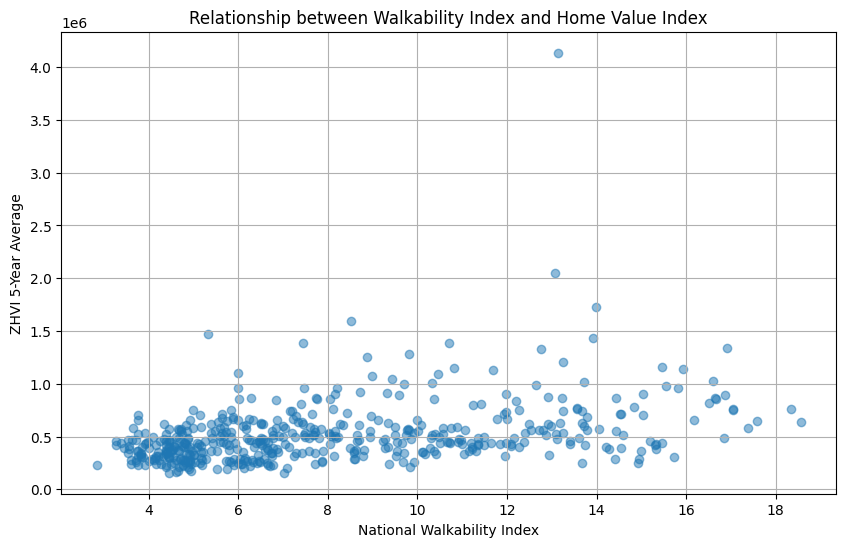

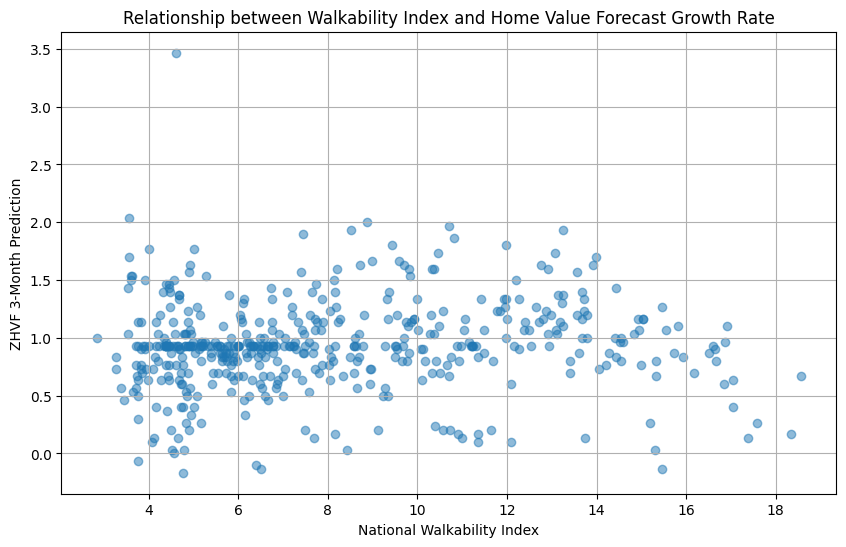

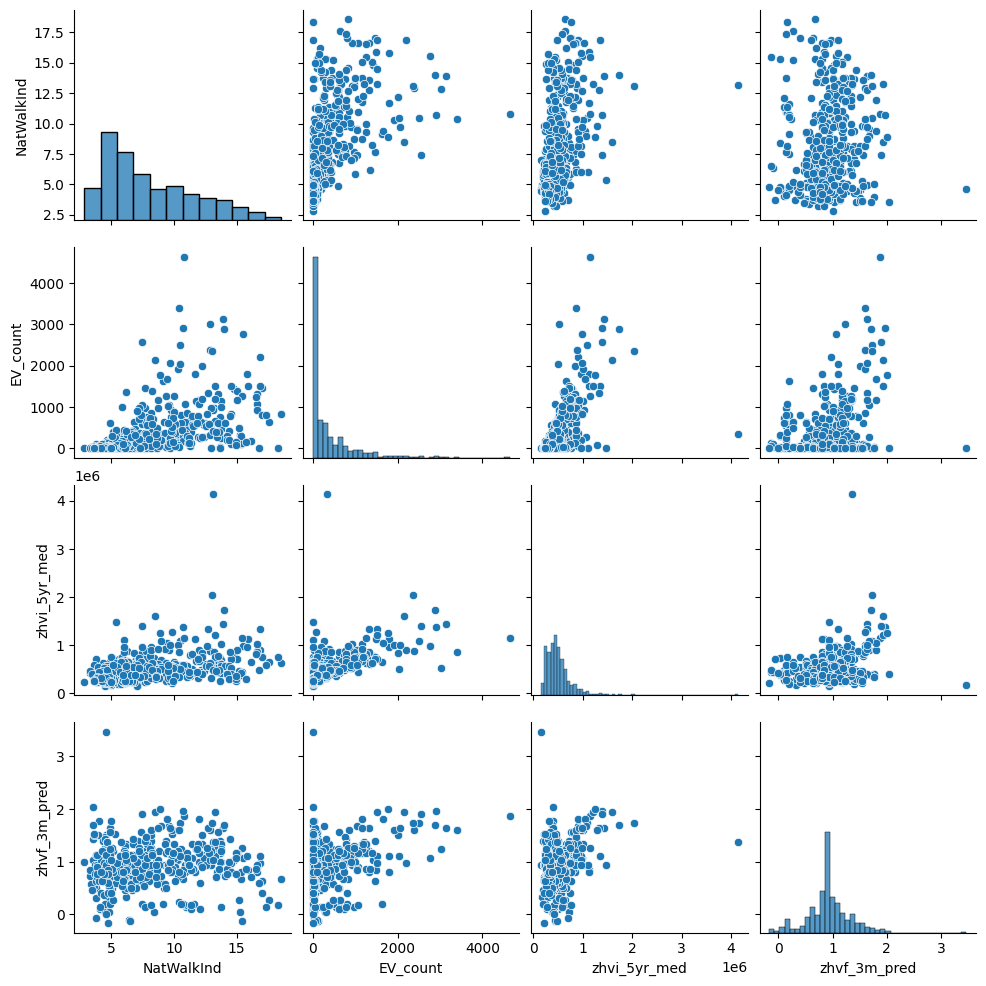

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(df['NatWalkInd'], df['zhvi_5yr_med'], alpha=0.5)
plt.title('Relationship between Walkability Index and Home Value Index')
plt.xlabel('National Walkability Index')
plt.ylabel('ZHVI 5-Year Average')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df['NatWalkInd'], df['zhvf_3m_pred'], alpha=0.5)
plt.title('Relationship between Walkability Index and Home Value Forecast Growth Rate')
plt.xlabel('National Walkability Index')
plt.ylabel('ZHVF 3-Month Prediction')
plt.grid(True)
plt.show()

sns.pairplot(df[['NatWalkInd', 'EV_count', 'zhvi_5yr_med', 'zhvf_3m_pred']])
plt.show()

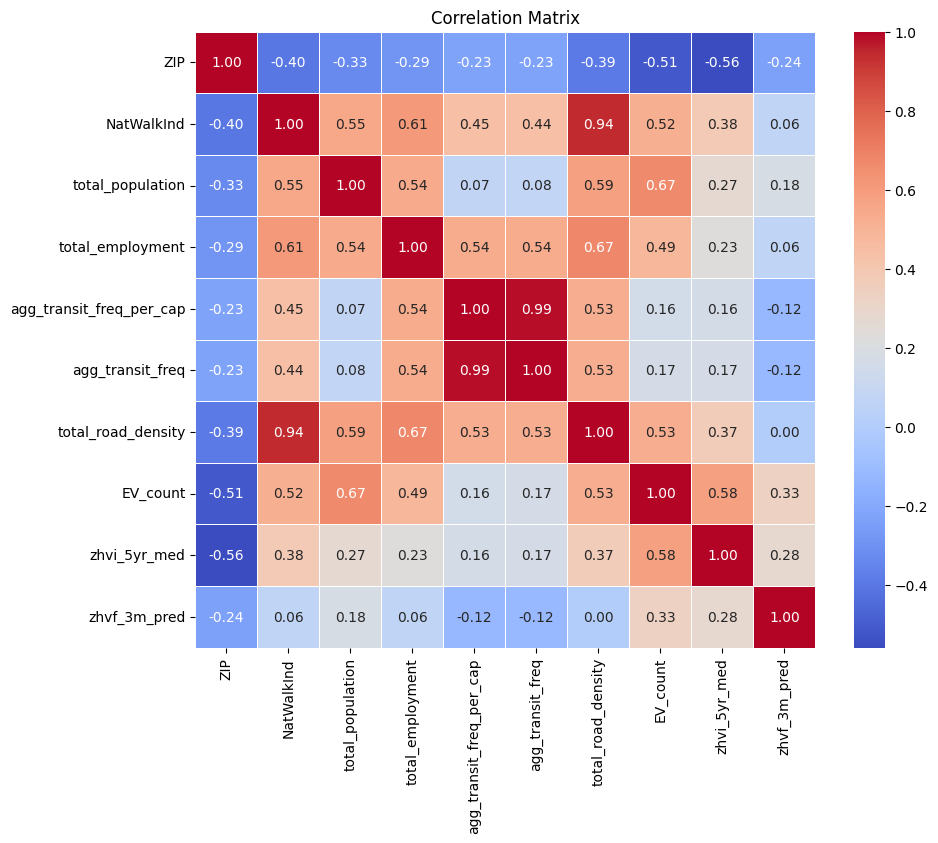

In [71]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Model coefficients: [ 5.90896762e+03 -3.20515359e+00 -2.43126689e+00 -1.00152843e+05
  1.95391722e+02  5.98254740e+03  3.55089802e+02]
Model intercept: 407719.1890067403
Mean Squared Error: 27847575865.97041
Root Mean Squared Error (RMSE): 166875.92955837102
Mean Absolute Error (MAE): 122557.5210190485
Normalized MSE: 0.017119363402405243
R^2 Score: 0.5811616154445174


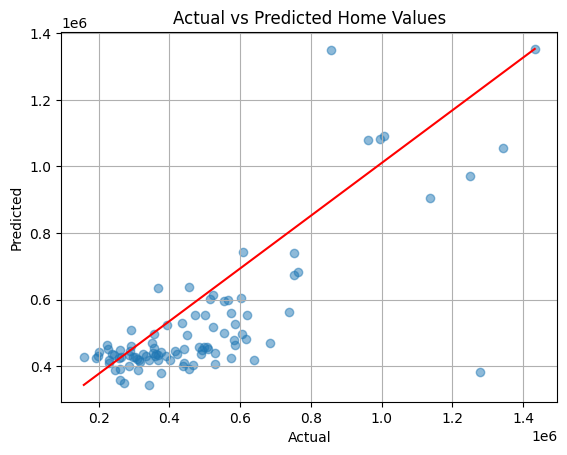

In [74]:
from sklearn.linear_model import LinearRegression

# Features and target (median home values) for regression
X = df[['NatWalkInd', 'total_population', 'total_employment', 'agg_transit_freq_per_cap',
        'agg_transit_freq', 'total_road_density', 'EV_count']]
y = df['zhvi_5yr_med']

# Split data set into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                                random_state = 42)
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Predict on the testing set
y_pred = lrm.predict(X_test)
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
normalized_mse = mse / (max(y_test) - min(y_test))**2
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Model coefficients:", lrm.coef_)
print("Model intercept:", lrm.intercept_)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Normalized MSE:", normalized_mse)
print("R^2 Score:", r2)

# Plot results
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Home Values')
# Line showing perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red')
plt.grid(True)
plt.show()

We created a heat map to see how correlated the features are with each other:

From the correlation matrix, we observed that some features are highly correlated with others. As a result, we wanted to try prediction with random forests in order to decorrelate the codel overall.

Feature ranking:
1. Feature 0, EV_count: 0.3334621614115939
2. Feature 5, agg_transit_freq: 0.17501441646527013
3. Feature 7, zhvf_3m_pred: 0.1524798138685466
4. Feature 3, total_employment: 0.12990120462759042
5. Feature 2, total_population: 0.07815825365624952
6. Feature 4, agg_transit_freq_per_cap: 0.058812827551331485
7. Feature 6, total_road_density: 0.043268707380200465
8. Feature 1, NatWalkInd: 0.028902615039217604

Mean Squared Error: 16482524709.888197
Root Mean Squared Error (RMSE): 128384.2852918074
Mean Absolute Error (MAE): 90679.68371599342
Normalized MSE: 0.010132671211877754
r^2 score:  0.7520964102544576



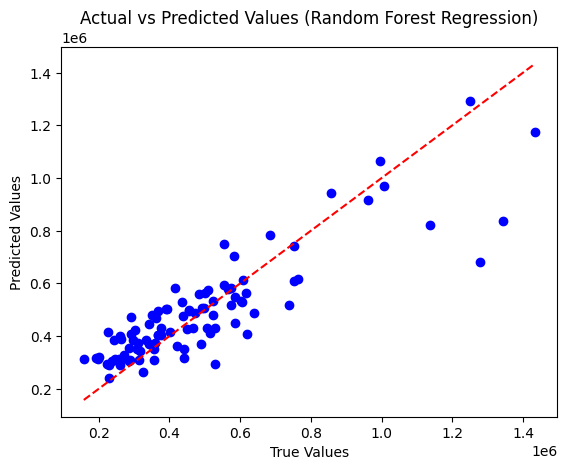

In [75]:
# random forest
from sklearn.ensemble import RandomForestRegressor

cols = ['EV_count', 'NatWalkInd', 'total_population', 'total_employment', 'agg_transit_freq_per_cap', 'agg_transit_freq', 'total_road_density','zhvf_3m_pred']
X = df[cols]
y = df['zhvi_5yr_med']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
normalized_mse = mse / (max(y_test) - min(y_test))**2
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

importance_scores = rf_regressor.feature_importances_
indices = np.argsort(importance_scores)[::-1]
print("Feature ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. Feature {idx}, {cols[idx]}: {importance_scores[idx]}")

print('')
print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Normalized MSE:", normalized_mse)
print('r^2 score: ', r2_score(y_test, y_pred))
print('')


plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest Regression)')
plt.show()

## XGBoost

In [76]:
'''
Create a sustainability score that takes weighted averages of
relevant metrics in our collected data. Takes into consideration each zipcodes EV count,
walkability index, total population, road density, transit frequency. We can potentially
categorize and therefore classify zipcodes based on this metric.
'''
# Normalize walkability, EV count, and road density by population
walk_pc = df['NatWalkInd'] / df['total_population']
ev_pc = df['EV_count'] / df['total_population']
road_pc = df['total_road_density'] / df['total_population']

# Normalize these per capita values
norm_walk = (walk_pc - walk_pc.min()) / (walk_pc.max() - walk_pc.min())
norm_ev = (ev_pc - ev_pc.min()) / (ev_pc.max() - ev_pc.min())
norm_road = (road_pc - road_pc.min()) / (road_pc.max() - road_pc.min())
# Aggregate transit frequency is already in per capita format
norm_trans_freq = (df['agg_transit_freq_per_cap'] - df['agg_transit_freq_per_cap'].min()) / (
                    df['agg_transit_freq_per_cap'].max() - df['agg_transit_freq_per_cap'].min())

# Weights for each factor in sustainability score; mess with them if we think one factor should weigh more
weights = {'walk': 0.25, 'ev': 0.25, 'road': 0.25, 'trans': 0.25}
# Add sustainability score to data frame
df['sustain_score'] = (weights['walk'] * norm_walk +
                       weights['ev'] * norm_ev +
                       weights['road'] * norm_road +
                       weights['trans'] * norm_trans_freq)
# Data exploration for validation
# print("Descriptive Statistics for Sustainability Score:", df['sustain_score'].describe())
# print("Correlation with Home Values:", df[['sustain_score', 'zhvi_5yr_med']].corr())

# df[['sustain_score']].hist(bins=30)
# plt.title('Distribution of Sustainability Scores')
# plt.show()

In [91]:
'''
Define target categories; can classify ZIP codes based on both the sustainability
score and the 3 month forecast growth prediction rate
'''
# Define categories based on quantiles
growth_quant = df['zhvf_3m_pred'].quantile([0.33, 0.66])
sustain_quant = df['sustain_score'].quantile([0.33, 0.66])

df['market_category'] = pd.cut(df['sustain_score'], bins=[0, sustain_quant[0.33],
                                sustain_quant[0.66], 1], labels=['Low Sustainability',
                                                                 'Medium Sustainability',
                                                                'High Sustainability'])
df['growth_category'] = pd.cut(df['zhvf_3m_pred'], bins=[df['zhvf_3m_pred'].min(),
                                growth_quant[0.33], growth_quant[0.66],
                                    df['zhvf_3m_pred'].max()], labels=['Declining',
                                                                        'Stable',
                                                                       'Growing'])

# Function that combines categories for a row and assigns class (used in pandas apply())
def classify_zip(zipcode):
    if zipcode['market_category'] == 'High Sustainability' and zipcode['growth_category'] == 'Growing':
        return 'High Sustainability & High Growth'
    elif zipcode['market_category'] == 'Low Sustainability' and zipcode['growth_category'] == 'Declining':
        return 'Low Sustainability & Declining Market'
    else:
        return 'Emerging Sustainability Market'

df['classf'] = pd.Categorical(df.apply(classify_zip, axis = 1))
df['classf_code'] = df['classf'].cat.codes
# Can comment if you want to see the intermediate categories assigned
df = df.drop(['market_category', 'growth_category'], axis = 1)

# df['classf'].value_counts()

classf
Emerging Sustainability Market           363
High Sustainability & High Growth         67
Low Sustainability & Declining Market     54
Name: count, dtype: int64

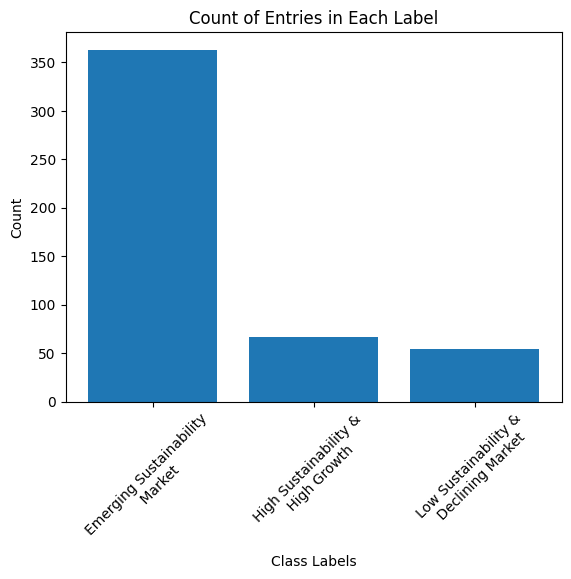

In [92]:
#visualization of the classified dataset
label_counts = df['classf_code'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel('Class Labels')
plt.xticks(range(len(label_counts)), ['Emerging Sustainability\n Market', 'High Sustainability &\n High Growth', 'Low Sustainability &\n Declining Market'], rotation = 45)

plt.ylabel('Count')
plt.title('Count of Entries in Each Label')

# Show plot
plt.show()

In [83]:
'''
With categories defined, we can apply a classifier model, particularly, XGBoost.
'''
import xgboost as xgb


def xgb_classify(df, feats, max_depth = 6): # TODO: catboost?
    X = df[feats]
    y = df['classf_code']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    xcm = xgb.XGBClassifier(objective = 'multi:softprob', num_class = 3, max_depth = max_depth)
    xcm.fit(X_train, y_train)

    y_pred = xcm.predict(X_test)
    print('Predicting from: ', ('all features' if len(feats) > 2 else feats))
    print('Current max depth: ', max_depth)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

# Fit model with all our fields to see how it performs
xgb_classify(df, ['NatWalkInd', 'total_population', 'total_employment',
                    'agg_transit_freq_per_cap', 'agg_transit_freq', 'total_road_density',
                    'EV_count', 'zhvi_5yr_med', 'zhvf_3m_pred'])
# Fit model with sustainability score and home value growth forecast rate averages
xgb_classify(df, ['sustain_score', 'zhvf_3m_pred'])

Predicting from:  all features
Current max depth:  6
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        79
           1       0.64      1.00      0.78         9
           2       0.78      0.78      0.78         9

    accuracy                           0.91        97
   macro avg       0.80      0.90      0.83        97
weighted avg       0.92      0.91      0.91        97

Accuracy: 0.9072164948453608
Predicting from:  ['sustain_score', 'zhvf_3m_pred']
Current max depth:  6
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        79
           1       0.82      1.00      0.90         9
           2       0.82      1.00      0.90         9

    accuracy                           0.96        97
   macro avg       0.88      0.98      0.92        97
weighted avg       0.97      0.96      0.96        97

Accuracy: 0.9587628865979382


In [90]:
#experimenting with parameters
depths = [3, 5, 7, 9, 11]
for depth in depths:
  xgb_classify(df, ['NatWalkInd', 'total_population', 'total_employment',
                    'agg_transit_freq_per_cap', 'agg_transit_freq', 'total_road_density',
                    'EV_count', 'zhvi_5yr_med', 'zhvf_3m_pred'], max_depth =5)

Predicting from:  all features
Current max depth:  5
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        79
           1       0.69      1.00      0.82         9
           2       0.80      0.89      0.84         9

    accuracy                           0.93        97
   macro avg       0.83      0.94      0.87        97
weighted avg       0.94      0.93      0.93        97

Accuracy: 0.9278350515463918
Predicting from:  all features
Current max depth:  5
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        79
           1       0.69      1.00      0.82         9
           2       0.80      0.89      0.84         9

    accuracy                           0.93        97
   macro avg       0.83      0.94      0.87        97
weighted avg       0.94      0.93      0.93        97

Accuracy: 0.9278350515463918
Predicting from:  all features
Current max depth:  5
              precisi

In [80]:
#cross validation
from sklearn.model_selection import cross_val_score

X = df[['NatWalkInd', 'total_population', 'total_employment',
                    'agg_transit_freq_per_cap', 'agg_transit_freq', 'total_road_density',
                    'EV_count', 'zhvi_5yr_med', 'zhvf_3m_pred']]
y = df['classf_code']
xcm_cv = xgb.XGBClassifier(objective = 'multi:softprob', num_class = 3, max_depth = 5)
scores = cross_val_score(xcm_cv, X, y, cv=5, scoring = 'accuracy')
print('Cross-validation scores (accuracy): ', scores)
print('Mean accuracy: ', np.mean(scores))
print('Standard deviation of accuracy: ', np.std(scores))

Cross-validation scores (accuracy):  [0.88659794 0.8556701  0.92783505 0.91752577 0.875     ]
Mean accuracy:  0.8925257731958762
Standard deviation of accuracy:  0.026729674561781814
